In [ ]:
import os
import zipfile
import random
import shutil
from pathlib import Path
import yaml

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted: {zip_path}")

def restructure_and_split(base_dir="dataset", train_ratio=0.8):
    # Assumes Roboflow format after unzip: dataset/train/images + labels
    original_train_img = Path(base_dir) / "train" / "images"
    original_train_lbl = Path(base_dir) / "train" / "labels"

    image_files = sorted(list(original_train_img.glob("*.jpg")) + list(original_train_img.glob("*.png")))
    random.shuffle(image_files)
    split_index = int(len(image_files) * train_ratio)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]

    # Make target folders
    for split in ['train', 'val']:
        (Path(base_dir) / "images" / split).mkdir(parents=True, exist_ok=True)
        (Path(base_dir) / "labels" / split).mkdir(parents=True, exist_ok=True)

    # Move files
    def move(files, split):
        for img_path in files:
            label_path = original_train_lbl / (img_path.stem + ".txt")
            shutil.copy2(img_path, Path(base_dir) / "images" / split / img_path.name)
            shutil.copy2(label_path, Path(base_dir) / "labels" / split / label_path.name)

    move(train_files, "train")
    move(val_files, "val")
    print(f"Split complete: {len(train_files)} train, {len(val_files)} val")

def update_yaml(yaml_path="dataset/data.yaml"):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    # Only update paths
    data['train'] = '../train/images'
    data['val'] = '../valid/images'
    data['test'] = '../test/images'

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f, default_flow_style=False, sort_keys=False)

    print("data.yaml updated with new paths only (format preserved)")

# 1. Unzip your Roboflow dataset (e.g., dataset/dataset.zip)
zip_file = "dataset/dataset.zip"
extract_zip(zip_file, "dataset")

# 2. Restructure & split
restructure_and_split("dataset")

# 3. Update data.yaml
update_yaml("dataset/data.yaml")

# Delete the original train folder
shutil.rmtree(Path("dataset") / "train")

# Delete ReadMe and License files
os.remove(Path("dataset") / "README.dataset.txt")
os.remove(Path("dataset") / "README.roboflow.txt")


In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
from ultralytics.utils.loss import v8DetectionLoss
import torch.optim as optim
from types import SimpleNamespace
from tqdm import tqdm

# ==== CONFIG ====
IMG_DIR_TRAIN = 'dataset/images/train'
LABEL_DIR_TRAIN = 'dataset/labels/train'
IMG_DIR_VAL = 'dataset/images/val'
LABEL_DIR_VAL = 'dataset/labels/val'
PRETRAINED_MODEL = 'model/yolo11n.pt'

NUM_CLASSES = 2
BATCH_SIZE = 8
EPOCHS = 1
IMG_SIZE = 640
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== CUSTOM DATASET ====
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=640):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.label_dir = label_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = os.path.join(self.label_dir, os.path.basename(img_path).replace('.jpg', '.txt'))

        image = cv2.imread(img_path)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image[:, :, ::-1]  # BGR to RGB
        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)

        boxes = []
        cls = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    c, x, y, w, h = map(float, parts)
                    boxes.append([x, y, w, h])
                    cls.append(int(c))

        target = {
            'bboxes': torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4)),
            'cls': torch.tensor(cls, dtype=torch.int64) if cls else torch.zeros((0,), dtype=torch.int64)
        }

        return image, target

# ==== VALIDATION FUNCTION ====
@torch.no_grad()
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss = 0

    for imgs, targets in val_loader:
        imgs = torch.stack(imgs).to(device)
        all_bboxes, all_cls, all_batch_idx = [], [], []

        for i in range(len(targets)):
            if len(targets[i]['bboxes']) == 0:
                continue
            all_bboxes.append(targets[i]['bboxes'])
            all_cls.append(targets[i]['cls'])
            all_batch_idx.append(torch.full((len(targets[i]['cls']),), i, dtype=torch.int64))

        if len(all_bboxes) == 0:
            continue

        formatted_targets = {
            'bboxes': torch.cat(all_bboxes).to(device),
            'cls': torch.cat(all_cls).to(device),
            'batch_idx': torch.cat(all_batch_idx).to(device),
        }

        preds = model(imgs)
        loss_tensor, _ = loss_fn(preds, formatted_targets)
        val_loss += loss_tensor.mean().item()


    return val_loss / len(val_loader)

# ==== LOAD MODEL ====
model_wrapper = YOLO(PRETRAINED_MODEL)
model = model_wrapper.model.to(DEVICE)

# ==== LOSS + OPTIMIZER ====
loss_fn = v8DetectionLoss(model)
loss_fn.hyp = SimpleNamespace(**{
    'box': 0.1,
    'cls': 0.3,
    'dfl': 1.5,
    'obj': 0.7,
    'fl_gamma': 2.0  # Focal Loss on
})
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ==== DATALOADER ====
train_dataset = YoloDataset(IMG_DIR_TRAIN, LABEL_DIR_TRAIN, img_size=IMG_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: list(zip(*x)))

val_dataset = YoloDataset(IMG_DIR_VAL, LABEL_DIR_VAL, img_size=IMG_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: list(zip(*x)))

# ==== TRAIN LOOP ====
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (imgs, targets) in enumerate(progress_bar):
        imgs = torch.stack(imgs).to(DEVICE)
        all_bboxes, all_cls, all_batch_idx = [], [], []

        for i in range(len(targets)):
            if len(targets[i]['bboxes']) == 0:
                continue
            all_bboxes.append(targets[i]['bboxes'])
            all_cls.append(targets[i]['cls'])
            all_batch_idx.append(torch.full((len(targets[i]['cls']),), i, dtype=torch.int64))

        if len(all_bboxes) == 0:
            continue

        formatted_targets = {
            'bboxes': torch.cat(all_bboxes).to(DEVICE),
            'cls': torch.cat(all_cls).to(DEVICE),
            'batch_idx': torch.cat(all_batch_idx).to(DEVICE),
        }

        for param in model.parameters():
            param.requires_grad = True


        preds = model(imgs)
        total_loss_tensor, _ = loss_fn(preds, formatted_targets)

        optimizer.zero_grad()
        total_loss_tensor = total_loss_tensor.mean()
        total_loss_tensor.backward()
        optimizer.step()

        total_loss += total_loss_tensor.item()
        progress_bar.set_postfix(batch_loss=total_loss_tensor.item(), avg_loss=total_loss / (batch_idx + 1))


    # === After training loop ===
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = validate(model, val_loader, loss_fn, DEVICE)

    # Print epoch results
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        torch.save(model.state_dict(), "model/yolov11_custom.pth")




Epoch 1/1: 100%|██████████| 132/132 [00:23<00:00,  5.60it/s, avg_loss=4.25, batch_loss=2.88]


Train Loss: 4.2491 | Val Loss: 3.4479



image 1/1 c:\Users\MoffyCream\Desktop\RealTimeAIMalaysianCarplateDetection\object_detection\dataset\images\val\1_jpg.rf.c09e68102ba96524fe2b4cde57eaff6d.jpg: 640x640 3 cars, 1 license_plate, 63.4ms
Speed: 5.8ms preprocess, 63.4ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


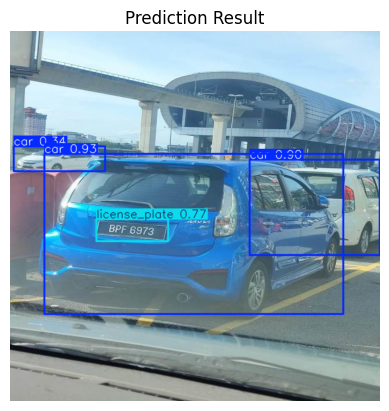

In [ ]:
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# === LOAD MODEL ===
CUSTOM_WEIGHTS = 'model/yolov11_custom.pth'
IMAGE_PATH = 'dataset/images/val/1_jpg.rf.c09e68102ba96524fe2b4cde57eaff6d.jpg'

# Load wrapper and custom weights
model_wrapper = YOLO(PRETRAINED_MODEL)
model_wrapper.model.load_state_dict(torch.load(CUSTOM_WEIGHTS, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
model_wrapper.model.eval()
model_wrapper.model.names = {0: "car", 1: "license_plate"}


# === RUN PREDICTION ===
results = model_wrapper.predict(source=IMAGE_PATH, imgsz=IMG_SIZE, conf=0.25) # High 

# === VISUALIZE RESULT ===
for r in results:
    # r.plot() returns an annotated BGR image (with boxes, labels)
    annotated_img = r.plot()

    # Convert BGR to RGB for displaying with matplotlib
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Show the result
    plt.imshow(annotated_img_rgb)
    plt.title("Prediction Result")
    plt.axis('off')
    plt.show()


# The Version below is  replacement codes for replacing HIGH LEVEL API like loss function, evaluating function and predict function

In [ ]:
from torch.utils.data import Dataset
import torch
import os
import cv2
from torch.utils.data import DataLoader

BATCH_SIZE = 8
IMAGE_SIZE = 640

class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=IMAGE_SIZE):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted([
        f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.img_size = img_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, image_filename)
        label_path = os.path.join(self.label_dir, image_filename.replace('.jpg', '.txt').replace('.png', '.txt'))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.img_size, self.img_size))
        # Normalize to [0, 1] and convert to float32
        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)  # C x H x W

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip().replace('\ufeff', '')  # remove BOM if present
                    parts = line.split()
                    if len(parts) >= 5:
                        try:
                            cls, x, y, w, h = map(float, parts[:5])  # use only first 5 values
                            boxes.append([cls, x, y, w, h])
                        except ValueError as e:
                            print(f"Skipping bad line in {label_path}: {line} ({e})")

        boxes = torch.tensor(boxes, dtype=torch.float32) 
        return image, boxes, os.path.basename(image_filename)


def yolo_collate_fn(batch):
    images = []
    targets = []
    filenames = []
    
    for img, boxes, fname in batch:
        images.append(img)
        targets.append(boxes)  # Do not stack — allow variable length
        filenames.append(fname)
    
    images = torch.stack(images, dim=0)  # Images are same size, safe to stack
    return images, targets, filenames


train_dataset = YoloDataset(
    image_dir="dataset/images/train",
    label_dir="dataset/labels/train",
    img_size=IMAGE_SIZE
)

val_dataset = YoloDataset(
    image_dir="dataset/images/val",
    label_dir="dataset/labels/val",
    img_size=IMAGE_SIZE
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=yolo_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=yolo_collate_fn
)



In [ ]:
import matplotlib.pyplot as plt

# Class labels (edit if you change order in data.yaml)
# Get labels from the data.yaml file
import yaml
with open("dataset/data.yaml", 'r') as f:
    data = yaml.safe_load(f)
class_labels = data['names']
class_colors = ['blue', 'red']
NUM_CLASSES = len(class_labels)

img, boxes, filename = train_dataset[0]
img_np = img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 8))
plt.imshow(img_np)

for box in boxes:
    cls, x, y, w, h = box
    cx, cy = x * 640, y * 640
    bw, bh = w * 640, h * 640
    x1, y1 = cx - bw / 2, cy - bh / 2

    cls = int(cls)
    label = class_labels[cls]
    color = class_colors[cls]

    plt.gca().add_patch(plt.Rectangle((x1, y1), bw, bh, edgecolor=color, linewidth=2, facecolor='none'))
    plt.text(x1, y1 - 5, label, color=color, fontsize=10, backgroundcolor='white')

plt.title(f"Preview: {filename}")
plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==== Config ====
IMG_PATH = "dataset/images/val/1_jpg.rf.c09e68102ba96524fe2b4cde57eaff6d.jpg"
IMG_SIZE = 640
CONF_THRESH = 0.25
IOU_THRESH = 0.45

# ==== Preprocess Image ====
img = cv2.imread(IMG_PATH)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_tensor = torch.tensor(img_rgb / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

# ==== Inference ====
model.eval()
with torch.no_grad():
    preds = model(img_tensor)[0]  # shape [batch, num_predictions, (classes + 5)]
    print("Type of preds:", type(preds))
    print("Pred shape:", preds[0].shape)
    print("Sample output:", preds[0][0][:10])

# ==== Apply NMS (Non-Max Suppression) ====
from torchvision.ops import nms

# Get predictions for first image in batch
pred = preds[0]  # shape: [num_preds, 85] if 80-class COCO (yours should be 7)

# Extract components
boxes = pred[:, :4]  # [x1, y1, x2, y2]
confidences = pred[:, 4] * pred[:, 5:].max(1).values  # object_conf * class_conf
class_ids = pred[:, 5:].argmax(1)

# Filter by confidence threshold
mask = confidences > CONF_THRESH
boxes = boxes[mask]
confidences = confidences[mask]
class_ids = class_ids[mask]

# Apply NMS
keep = nms(boxes, confidences, iou_threshold=IOU_THRESH)

# Final results
boxes = boxes[keep].cpu().numpy()
confidences = confidences[keep].cpu().numpy()
class_ids = class_ids[keep].cpu().numpy()


Type of preds: <class 'torch.Tensor'>
Pred shape: torch.Size([84, 8400])
Sample output: tensor([13.7545, 18.3520, 19.2723, 19.5077, 39.1890, 45.1030, 48.1907, 53.8272, 65.8475, 79.7903], device='cuda:0')


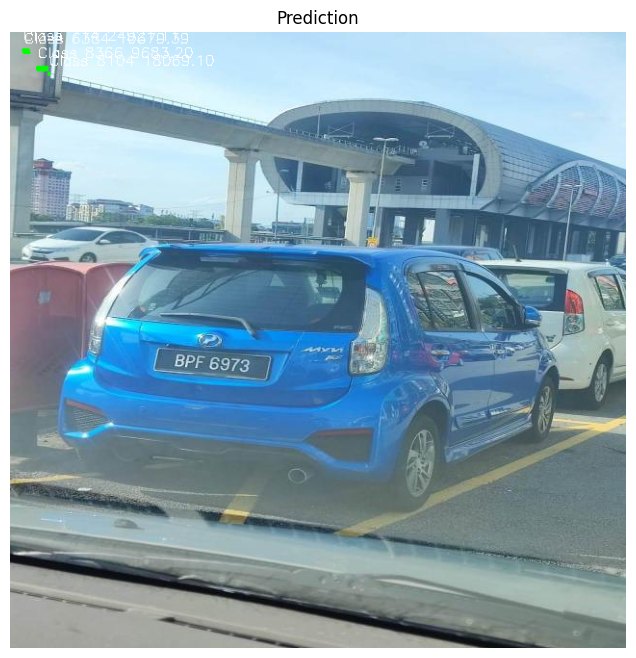

In [8]:
# Draw results
for box, conf, cls in zip(boxes, confidences, class_ids):
    x1, y1, x2, y2 = box.astype(int)
    label = f"Class {cls} {conf:.2f}"
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Prediction")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_iou(box1, box2):
    """
    box1: [1, 4], box2: [N, 4] in format [x, y, w, h]
    Returns: IoU [N]
    """
    x1_min = box1[:, 0] - box1[:, 2] / 2
    y1_min = box1[:, 1] - box1[:, 3] / 2
    x1_max = box1[:, 0] + box1[:, 2] / 2
    y1_max = box1[:, 1] + box1[:, 3] / 2

    x2_min = box2[:, 0] - box2[:, 2] / 2
    y2_min = box2[:, 1] - box2[:, 3] / 2
    x2_max = box2[:, 0] + box2[:, 2] / 2
    y2_max = box2[:, 1] + box2[:, 3] / 2

    inter_xmin = torch.max(x1_min, x2_min)
    inter_ymin = torch.max(y1_min, y2_min)
    inter_xmax = torch.min(x1_max, x2_max)
    inter_ymax = torch.min(y1_max, y2_max)

    inter_area = (inter_xmax - inter_xmin).clamp(0) * (inter_ymax - inter_ymin).clamp(0)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = area1 + area2 - inter_area
    return inter_area / (union_area + 1e-6)


def compute_yolo_loss(preds, targets, img_size=640):
    """
    preds: List[Tensor], usually length 1, shape: [B, N, 6] -> [x, y, w, h, obj, class]
    targets: [B, num_boxes, 5] -> [class, x_center, y_center, w, h] (normalized)
    """
    device = preds[0].device
    loss_obj = 0
    loss_box = 0
    loss_cls = 0
    lambda_obj = 1.0
    lambda_box = 5.0
    lambda_cls = 1.0

    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()
    
    pred = preds
    B, N, _ = pred.shape

    for b in range(B):
        pred_boxes = pred[b, :, :4]  # [N, 4]
        pred_obj = pred[b, :, 4]     # [N]
        pred_cls = pred[b, :, 5]     # [N]

        target = targets[b]  # [num_objs, 5]
        if target.nelement() == 0:
            # No object, only penalize objectness
            loss_obj += bce(pred_obj, torch.zeros_like(pred_obj).to(device))
            continue

        # Matching: naive version – compare each target with all preds (slow but simple)
        for t in target:
            cls, tx, ty, tw, th = t
            gx = tx * img_size
            gy = ty * img_size
            gw = tw * img_size
            gh = th * img_size
            gt_box = torch.tensor([gx, gy, gw, gh]).to(device)

            # Calculate IoU with all pred boxes
            ious = compute_iou(gt_box.unsqueeze(0), pred_boxes * img_size)
            best_idx = torch.argmax(ious)

            # Box regression loss
            pred_box = pred_boxes[best_idx]
            pred_box = pred_box * img_size
            loss_box += mse(pred_box, gt_box)

            # Objectness: positive at best_idx
            loss_obj += bce(pred_obj[best_idx], torch.tensor(1.0).to(device))

            # Classification loss
            target_cls = torch.tensor([cls]).to(device)
            pred_class_score = pred_cls[best_idx].unsqueeze(0)
            loss_cls += bce(pred_class_score, torch.tensor([1.0]).to(device))  # binary since 1 class

        # Background objectness penalty
        for i in range(N):
            if i != best_idx:
                loss_obj += bce(pred_obj[i], torch.tensor(0.0).to(device))

    total_loss = lambda_box * loss_box + lambda_obj * loss_obj + lambda_cls * loss_cls
    return total_loss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.train()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

for epoch in range(20):
    running_loss = 0.0
    for imgs, targets, _ in train_loader:
        imgs = imgs.to(device)
        targets = [t.to(device) for t in targets]

        optimizer.zero_grad()

        preds = model(imgs)

        if isinstance(preds, (tuple, list)):
            all_preds = []
            for i, p in enumerate(preds):
                # p.shape: [B, C=144, H, W]
                B, C, H, W = p.shape
                A = 3  # usually 3 anchors
                num_classes = C // A - 5  # (C = A × (5 + num_classes))

                # Split channels per anchor → [B, A, 5+num_classes, H, W]
                p = p.view(B, A, 5 + num_classes, H, W)

                # Permute to [B, A, H, W, 5+num_classes]
                p = p.permute(0, 1, 3, 4, 2).contiguous()

                # For your loss, you can reduce it to 6 if only 1 class:
                # slice only the first 6 values: [x, y, w, h, obj, cls]
                p = p[..., :6]  # drop extra classes if needed

                # Flatten to [B, N, 6]
                p = p.view(B, -1, 6)

                all_preds.append(p)

            preds = torch.cat(all_preds, dim=1)  # [B, total_N, 6]
        else:
            raise ValueError("Model did not return a list/tuple of tensors.")



        loss = compute_yolo_loss(preds, targets)
        loss.backward()
        optimizer.step()



    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")
